In [1]:
%matplotlib inline

In [2]:
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)

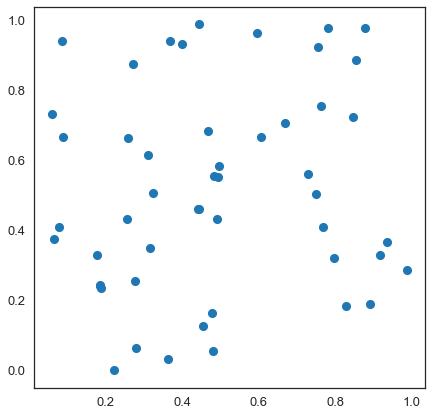

In [3]:
import numpy as np

prng = np.random.RandomState(7890)
data = prng.rand(50, 2)

plt.plot(data[:, 0], data[:, 1], 'o');

In [4]:
def distance(x0, x1):
    return np.linalg.norm(x0 - x1)

In [5]:
from collections import namedtuple

Tree = namedtuple("Tree", ["vantage_point", "mu", "left", "right"])

In [6]:
prng = np.random.RandomState(1234)


def build(points, tree=None):
    
    # Take a random vantage point
    vantage_index = prng.randint(0, len(points))
    vantage_point = points.pop(vantage_index)
    
    #
    if len(points) == 0:
        return Tree(vantage_point, 0, None, None)
    
    # Compute distances to other points
    distances = [distance(vantage_point, pt) for pt in points]
    
    # Median distance
    mu = np.median(distances)
    
    # Divide points into further and closer
    closer, further = [], []
    for d, pt in zip(distances, points):
        if d < mu:
            closer.append(pt)
        else:
            further.append(pt)
          
    # Recurse!
    if closer:
        left = build(closer)
    else:
        left = None
    if further:
        right = build(further)
    else:
        right = None
    
    return Tree(vantage_point, mu, left, right)

In [7]:
# Make a copy
points = list(data)

tree = build(points)

In [8]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from collections import deque

NX_DEFAULTS = {
    'with_labels': False,
    'arrows': False,
    'node_size': 200
}

def _plot_nodes(ax, G, pos, **kwds):
    defaults = NX_DEFAULTS.copy()
    defaults.update(kwds)
    nx.draw_networkx_nodes(G, pos, ax=ax, **defaults)
    
def _plot_edges(ax, G, pos, **kwds):
    defaults = NX_DEFAULTS.copy()
    defaults.update(kwds)
    nx.draw_networkx_edges(G, pos, ax=ax, **defaults)

def _id(tree):
    return str(tree.vantage_point)

def _graph_from_tree(tree):
    G = nx.DiGraph()
    
    q = deque([tree])
    while q:
        top = q.popleft()
        left = top.left
        if left:
            G.add_edge(_id(top), _id(left))
            q.append(left)
        right = top.right
        if right:
            G.add_edge(_id(top), _id(right))
            q.append(right)
            
    return G


def plot_tree_simple(G, ax, **kwds):

    pos = graphviz_layout(G, prog='dot')

    _plot_edges(ax, G, pos)
    _plot_nodes(ax, G, pos)
    
    ax.axis('off')

In [9]:
G = _graph_from_tree(tree)

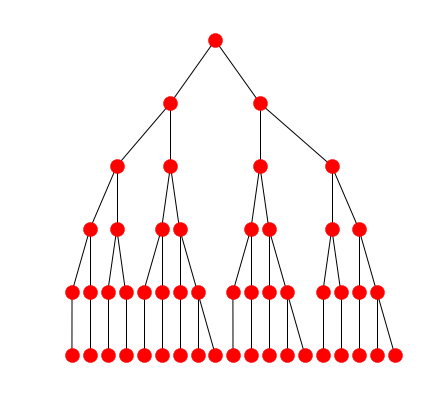

In [10]:
fig, ax = plt.subplots()
plot_tree_simple(G, ax);

In [25]:
from matplotlib.patches import Circle

def _bfs(tree):
    if tree is None:
        return []
    ids = []
    pts = []
    q = deque([tree])
    while q:
        top = q.popleft()
        pts.append(top.vantage_point)
        ids.append(_id(top))
        if top.left:
            q.append(top.left)
        if top.right:
            q.append(top.right)
    return ids, np.array(pts)


def plot_lr(ax, tree, data):
    ax.plot(data[:, 0], data[:, 1], 'o', c='lightgray')
    
    # plot vantage point
    ax.plot(*tree.vantage_point, 'ro')
    
    # plot close points
    _, left = _bfs(tree.left)
    ax.plot(left[:, 0], left[:, 1], 'ko')

    # plot further points
    _, right = _bfs(tree.right)
    ax.plot(right[:, 0], right[:, 1], 'o', c='blue')
    
    #
    e = Circle(xy=tree.vantage_point, radius=tree.mu)
    ax.add_artist(e)
    e.set_edgecolor('gray')
    e.set_facecolor('none')
    e.set_linewidth(2.0)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    return e

In [31]:
from shapely.geometry import Point, box
from matplotlib.patches import PathPatch

In [32]:
def _make_circle_clipping_path_internal(xy, r):
    circle = Point(*xy).buffer(r)
    vertices = np.asarray(circle.exterior)
    codes = np.full(vertices.shape[0], Path.LINETO)
    codes[0] = Path.MOVETO
    return Path(vertices, codes)

def _make_circle_clipping_path_external(xy, r):
    #rect = box(0, 0, 1, 1)
    rect = box(-5, -5, 5, 5)
    circle = Point(*xy).buffer(r)
    polygon = rect.difference(circle)
    
    vs_ext = np.asarray(polygon.exterior)
    codes_ext = np.full(vs_ext.shape[0], Path.LINETO)
    codes_ext[0] = Path.MOVETO
    
    if polygon.interiors:
        vs_int = np.concatenate([np.asarray(r) for r in polygon.interiors])
        codes_int = np.full(vs_int.shape[0], Path.LINETO)
        codes_int[0] = Path.MOVETO
    else:
        vs_int = np.empty((0, 2), dtype=float)
        codes_int = np.empty((0), dtype=int)
        
    vertices = np.concatenate((vs_ext, vs_int))
    codes = np.concatenate((codes_ext, codes_int))
    
    return Path(vertices, codes)

def make_clipping_patch(xy, r, color='none', external=False):
    if external:
        p = _make_circle_clipping_path_external(xy, r)
    else:
        p = _make_circle_clipping_path_internal(xy, r)
    return PathPatch(p, facecolor='none', edgecolor=color)

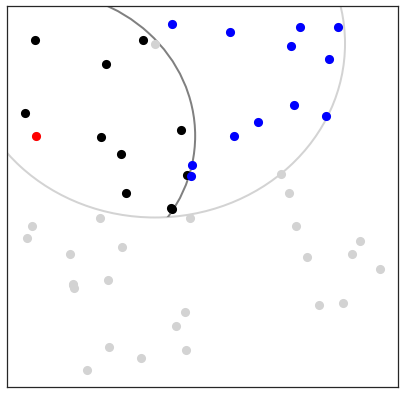

In [33]:
fig, ax = plt.subplots()
e = plot_lr(ax, tree.left, data)

c = Circle(tree.vantage_point, tree.mu, edgecolor='lightgray', facecolor='none', linewidth=2)
ax.add_patch(c)

e.set_clip_path(c)

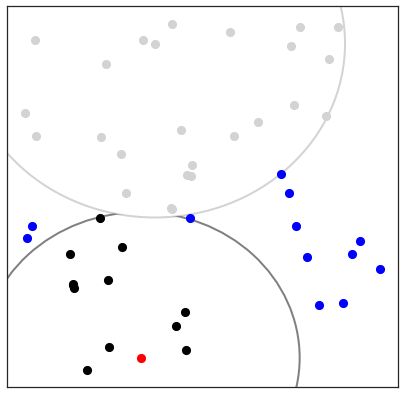

In [37]:
fig, ax = plt.subplots()
e = plot_lr(ax, tree.right, data)

c = Circle(tree.vantage_point, tree.mu, edgecolor='lightgray', facecolor='none', linewidth=2)
ax.add_patch(c)

cl_path = make_clipping_patch(tree.vantage_point, tree.mu, external=True)
ax.add_patch(cl_path)
e.set_clip_path(cl_path)

In [13]:
def plot_vp_tree(ax, G, subtree):
    
    vp_node_id = _id(subtree)
    left_ids, _ = _bfs(subtree.left)
    right_ids, _ = _bfs(subtree.right)
   
    pos = graphviz_layout(G, prog='dot')

    _plot_edges(ax, G, pos)
    _plot_nodes(ax,  G, pos, node_color='gray')    
    _plot_nodes(ax, G, pos, node_color='red', nodelist=[vp_node_id])     
    _plot_nodes(ax, G, pos, node_color='black', nodelist=left_ids)     
    _plot_nodes(ax, G, pos, node_color='blue', nodelist=right_ids)     
    
    ax.axis('off')

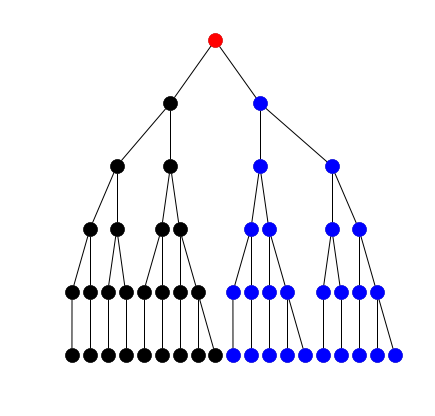

In [14]:
fig, ax = plt.subplots()
plot_vp_tree(ax, G, tree)

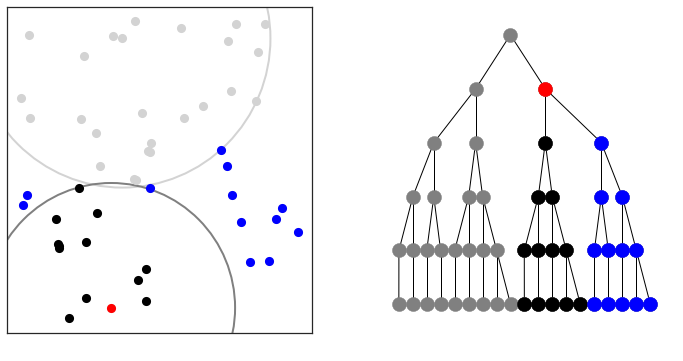

In [21]:
subtree = tree.right

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))

plot_lr(ax0, subtree, data)


# super boundary
c = Circle(tree.vantage_point, tree.mu, edgecolor='lightgray', facecolor='none', linewidth=2)
ax0.add_patch(c)


plot_vp_tree(ax1, G, subtree)

In [16]:
from matplotlib.transforms import IdentityTransform

In [17]:
from matplotlib.path import Path

def create_circle_path(xy, r, n=10):
    th = np.linspace(0, 2*np.pi, n)[::-1]
    x = xy[0] + r * np.cos(th)
    y = xy[1] + r * np.sin(th)
    codes = np.full(n, Path.LINETO)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    return Path(
        np.column_stack((x, y)),
        codes
    )

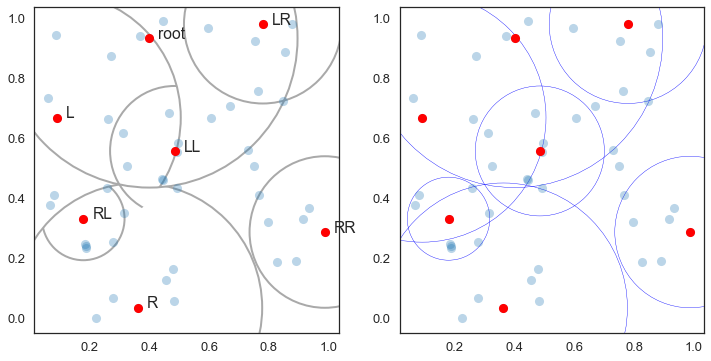

In [20]:
def _plot_clip(ax, tree, max_depth=3, depth=0, label='root'):        
    
    shape = Circle(xy=tree.vantage_point, radius=tree.mu, facecolor='none', edgecolor='darkgray', linewidth=2)
    ax.add_artist(shape)
    ax.plot(*tree.vantage_point, 'o', c='red')
    ax.annotate(xy=tree.vantage_point + [0.03, 0], s=label)

    if depth >= max_depth:
        return shape
    
    if label == 'root':
        label = ''
    left_label = label + 'L'
    right_label = label + 'R'
    
    left_artist, right_artist = None, None
    if tree.left:
        left_artist = _plot_clip(ax, tree.left, max_depth, depth + 1, label=left_label)
    if tree.right:
        right_artist = _plot_clip(ax, tree.right, max_depth, depth + 1, label=right_label)

    if left_artist:
        clip_left = make_clipping_patch(tree.vantage_point, tree.mu)
        ax.add_artist(clip_left)
        left_artist.set_clip_path(clip_left)
    if right_artist:
        clip_right = make_clipping_patch(tree.vantage_point, tree.mu, external=True)
        ax.add_artist(clip_right)
        right_artist.set_clip_path(clip_right)
    return shape

def _plot_noclip(ax, tree, depth=3):

    shape = Circle(xy=tree.vantage_point, radius=tree.mu, facecolor='none', edgecolor='blue')
    ax.add_artist(shape)
    ax.plot(*tree.vantage_point, 'ro')
    
    if depth <= 1:
        return shape
    
    left_artist, right_artist = None, None
    if tree.left:
        left_artist = _plot_noclip(ax, tree.left, depth-1)
    if tree.right:
        right_artist = _plot_noclip(ax, tree.right, depth-1)

    return shape

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))

ax0.plot(*data.T, 'o', alpha=0.3)
ax1.plot(*data.T, 'o', alpha=0.3)

subtree = tree

_plot_clip(ax0, subtree, max_depth=2)
_plot_noclip(ax1, subtree, depth=3)

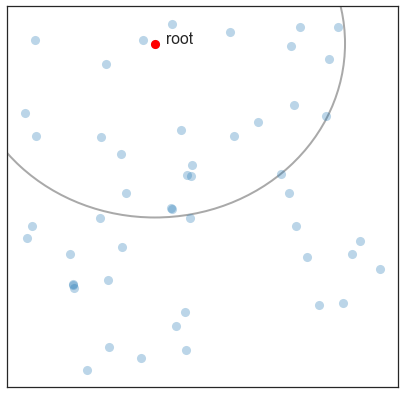

In [43]:
fig, ax = plt.subplots()

ax.plot(*data.T, 'o', alpha=0.3)
_plot_clip(ax, tree, max_depth=0)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

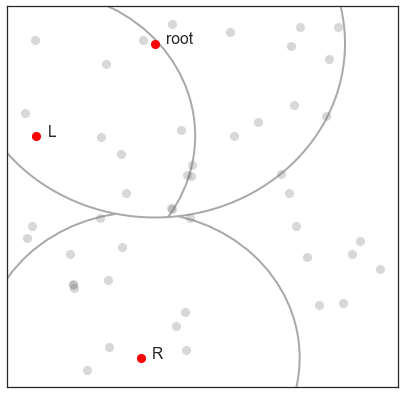

In [27]:
fig, ax = plt.subplots()

ax.plot(*data.T, 'o', alpha=0.3, color='gray')
_plot_clip(ax, tree, max_depth=1)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

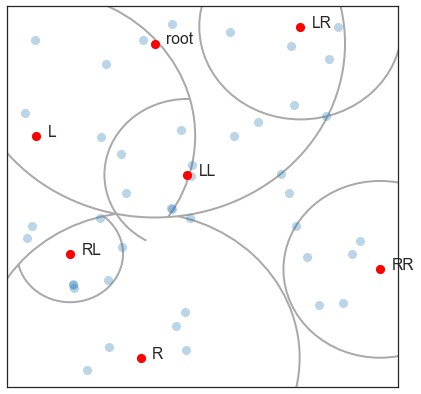

In [55]:
fig, ax = plt.subplots()

ax.plot(*data.T, 'o', alpha=0.3)
_plot_clip(ax, tree, max_depth=2)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

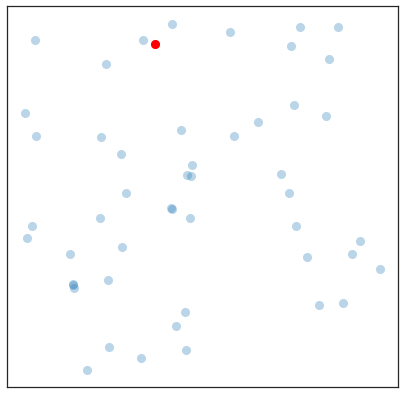

In [44]:
# just the vp

fig, ax = plt.subplots()

ax.plot(*data.T, 'o', alpha=0.3)
ax.plot(*tree.vantage_point, 'ro')

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);